---
### *The 12th Computational Neuroscience Winter School*

# Tutorial II: Neuron software
---
__Date:__ Jan. 13, 2023

__Content Creator:__ Jingyang Ma, Ziling Wang, Kai Chen, Songting Li

# Tutorial Objectives

In this notebook, we'll learn how to use the Neuron software in python to build the biophysical neuron(or neuronal network) and do some simulations as we like. There are 4 sections in this tutorial:

1. Simulation of  a point neuron
1. Simulation of neuron with dendtrites
1. Simulation of neuronal network
1. Simulation of a real neuron from ModelDB

#### References:
- https://www.neuron.yale.edu/neuron/static/py_doc/index.html
- https://neuronaldynamics.epfl.ch
- https://senselab.med.yale.edu/ModelDB/
- Li, S., Liu, N., Zhang, X., Zhou, D., Cai, D. (2014) Bilinearity in spatiotemporal integration of synaptic inputs. PLoS Comput Biol.
- Li, S., Liu, N., Zhang, X., McLaughlin, D. W., Zhou, D., & Cai, D. (2019). Dendritic computations captured by an effective point neuron model. Proceedings of the National Academy of Sciences.
- Hay E, Hill S, Schürmann F, Markram H, Segev I (2011) Models of Neocortical Layer 5b Pyramidal Cells Capturing a Wide Range of Dendritic and Perisomatic Active Properties. PLoS Comput Biol.

# Neuron software introduction

![NERUON](./pictures/NEURON.png)

![bilinear](./pictures/bilinear.png)

NEURON is a simulation software used to simulate a single neuron or neuronal network. It is suitable to simulate neurons with complex geometry and abundant ion channels and their neural circuits. The feature of this software is that when conducting numerical simulation, users only need to consider the geometric shape parameters of neurons, biophysical parameters and connections between neurons and other information, without considering the numerical solution method behind.

It was primarily developed by Michael Hines, John W. Moore, and Ted Carnevale at Yale and Duke in 1997. A NEURON project usually has three code formats:.hoc,.mod, and.ses. And use a specific software to do some simulation(see below). Today we mainly focus on the Python interface of NEURON which is more convenient and easy to learn.

![Neurongui](./pictures/Neurongui.png)

---
# Setup

Use **pip3 install neuron** to install the neuron package in python

In [1]:
!pip3 install neuron

  Cache entry deserialization failed, entry ignored
    100% |████████████████████████████████| 12.6MB 88kB/s eta 0:00:011    82% |██████████████████████████▎     | 10.4MB 31.6MB/s eta 0:00:01
  Cache entry deserialization failed, entry ignored
    100% |████████████████████████████████| 13.4MB 90kB/s  eta 0:00:01


There are only a limited number of functions avaiable directly from the neuron module. In practice, we usually want to directly import the submodules we need

In [1]:
from neuron import h

--No graphics will be displayed.


NEURON assumes certain default units (concentration in mM, time in ms, voltage in mV), but units can be specified explicitly by importing unit definitions from neuron.units. Even if you are using the default units, being explicit makes your code more readable by others. For example:

In [2]:
from neuron.units import ms, mV

# Section 1: Simulation of  a point neuron

## Step 1: Create a soma and check its morphological properties

A **Section** is the basic morphological building-block in NEURON. We typically think of a Section as an unbranched cable(cylinder), but it can also be used to represent a soma. Thus a simple model neuron with only a soma can be created as in:

In [6]:
soma = h.Section(name='soma')

![soma](./pictures/soma.png)

Every NEURON section has a **psection** method (think: properties of the section) that returns a Python dictionary providing a structured data representation of the properties of the section.
For example, we can query the soma via:

In [4]:
soma.psection()

{'point_processes': {},
 'density_mechs': {},
 'ions': {},
 'morphology': {'L': 100.0,
  'diam': [500.0],
  'pts3d': [],
  'parent': None,
  'trueparent': None},
 'nseg': 1,
 'Ra': 35.4,
 'cm': [1.0],
 'regions': set(),
 'species': set(),
 'name': 'soma',
 'hoc_internal_name': '__nrnsec_0x55a28b2289a0',
 'cell': None}

NEURON itself has default unit for different Physical quantities. And we can use **h.units()** to check it

In [5]:
h.units('L')

'um'

The results tell us the soma is a cylinder with length 100 microns, diameter 500 microns, axial resistivity 35.4 ohm*cm, and specific membrance capacitance 1 μF/cm2.

Since this is a dictionary, we can extract any properties we want using square brackets. For example, the length of the section is:

In [6]:
soma.psection()['morphology']['L']

100.0

All of these values can be individually accessed in more efficient ways, but psection provides an overview of the full properties of the section.

For example, the length of the soma is more efficiently available via:

In [7]:
soma.L

100.0

Important: You may have noticed that the default diameter is 500 μm, which is excessively large for mammalian neurons. It's the default because it's appropriate for the squid giant axons studied by Hodgkin and Huxley. NEURON also uses squid-relevant values for axial resistivity (soma.Ra) and temperature (h.celsius). These should all be adjusted for mammalian models.

## Step 2: Change the default value

Since we're simulating a soma, the default length of 100 μm and diameter of 500 μm are inappropriate. Let's set the length (L) and diameter (diam) to 20 μm instead:

In [7]:
soma.L = 20
soma.diam = 20

In [9]:
soma.psection()

{'point_processes': {},
 'density_mechs': {},
 'ions': {},
 'morphology': {'L': 20.0,
  'diam': [20.0],
  'pts3d': [],
  'parent': None,
  'trueparent': None},
 'nseg': 1,
 'Ra': 35.4,
 'cm': [1.0],
 'regions': set(),
 'species': set(),
 'name': 'soma',
 'hoc_internal_name': '__nrnsec_0x55a28b2289a0',
 'cell': None}

## Step 3: Insert ion channels

The cell membrane consists of a thin bilayer of lipids and is a nearly perfect electrical insulator. Embedded in the cell membrane are, however, specific proteins which act as ion gates. A first type of gate is the ion pumps, a second one is ion channels. Ion pumps actively transport ions from one side to the other. As a result, ion concentrations in the intracellular liquid differ from those of the surround. For example, the sodium concentration inside a mammalian neuron (≈ 10 mM) is lower than that in the extracellular liquid (≈ 145 mM). On the other hand, the potassium concentration inside is higher (≈ 140 mM) than in the surround (≈ 5 mM) (Purves et al., 2008). For the giant axon of the squid which was studied by Hodgkin and Huxley the numbers are slightly different, but the basic idea is the same: there is more sodium outside the cell than inside, while the reverse is true for potassium.

![ionchannel](./pictures/ionchannel.png)

NEURON comes with a few built in biophysical mechanisms that can be added to a model:

**pas**:	Passive (“leaky”) channel.

**hh**:	Hodgkin-Huxley sodium, potassium, and leakage channels.

Thousands of additional mechanisms (for A-currents, etc) are available as MOD files as part of published model codes on ModelDB(https://senselab.med.yale.edu/ModelDB/).

A section's insert method is used to insert density mechanisms. Let's insert Hodgkin-Huxley channels into the soma's membrane. We do this by passing 'hh' as the mechanism type:

In [10]:
soma.insert('hh')

soma

In [11]:
soma.psection()

{'point_processes': {},
 'density_mechs': {'hh': {'gnabar': [0.12],
   'gkbar': [0.036],
   'gl': [0.0003],
   'el': [-54.3],
   'gna': [0.0],
   'gk': [0.0],
   'il': [0.0],
   'm': [0.0],
   'h': [0.0],
   'n': [0.0]}},
 'ions': {'na': {'ena': [50.0],
   'nai': [10.0],
   'nao': [140.0],
   'ina': [0.0],
   'dina_dv_': [0.0]},
  'k': {'ek': [-77.0],
   'ki': [54.4],
   'ko': [2.5],
   'ik': [0.0],
   'dik_dv_': [0.0]}},
 'morphology': {'L': 20.0,
  'diam': [20.0],
  'pts3d': [],
  'parent': None,
  'trueparent': None},
 'nseg': 1,
 'Ra': 35.4,
 'cm': [1.0],
 'regions': set(),
 'species': set(),
 'name': 'soma',
 'hoc_internal_name': '__nrnsec_0x55a28b2289a0',
 'cell': None}

## Step 4: Insert a stimulus

Let's insert a current clamp (an IClamp object) into the center of the soma to induce some membrane dynamics.

In [12]:
iclamp = h.IClamp(soma(0.5))

In particular, we notice three key properties of a current clamp: amp -- the amplitude (in nA), delay -- the time the current clamp switches on (in ms), and dur -- how long (in ms) the current clamp stays on. Let's set these values:

In [13]:
iclamp.delay = 2
iclamp.dur = 0.1
iclamp.amp = 0.9

We can also use the **dir()** function to check all the callable properties of the variable

In [14]:
dir(iclamp)

['__abs__',
 '__add__',
 '__bool__',
 '__call__',
 '__class__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__next__',
 '__pos__',
 '__radd__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmul__',
 '__rsub__',
 '__rtruediv__',
 '__setattr__',
 '__setitem__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 'amp',
 'baseattr',
 'delay',
 'dur',
 'get_loc',
 'get_segment',
 'has_loc',
 'hname',
 'hocobjptr',
 'i',
 'loc',
 'same']

Let's use psection to get a representation of the soma model:

In [15]:
soma.psection()

{'point_processes': {'IClamp': {IClamp[0]}},
 'density_mechs': {'hh': {'gnabar': [0.12],
   'gkbar': [0.036],
   'gl': [0.0003],
   'el': [-54.3],
   'gna': [0.0],
   'gk': [0.0],
   'il': [0.0],
   'm': [0.0],
   'h': [0.0],
   'n': [0.0]}},
 'ions': {'na': {'ena': [50.0],
   'nai': [10.0],
   'nao': [140.0],
   'ina': [0.0],
   'dina_dv_': [0.0]},
  'k': {'ek': [-77.0],
   'ki': [54.4],
   'ko': [2.5],
   'ik': [0.0],
   'dik_dv_': [0.0]}},
 'morphology': {'L': 20.0,
  'diam': [20.0],
  'pts3d': [],
  'parent': None,
  'trueparent': None},
 'nseg': 1,
 'Ra': 35.4,
 'cm': [1.0],
 'regions': set(),
 'species': set(),
 'name': 'soma',
 'hoc_internal_name': '__nrnsec_0x55a28b2289a0',
 'cell': None}

## Step 5: Run the simulation and record the data

The cell should be configured to run a simulation. However, we need to indicate which variables we wish to record; these will be stored in a **NEURON Vector** (h.Vector object). For now, we will record the membrane potential, which is soma(0.5).v and the corresponding time points (h.t). References to variables are available by preceding the last part of the variable name with a _ref_

In [16]:
v = h.Vector().record(soma(0.5)._ref_v)             # Membrane potential vector
t = h.Vector().record(h._ref_t)                     # Time stamp vector

By default, the NEURON h module provides the low level fadvance function for advancing one time step. For higher-level simulation control specification, we load NEURON's stdrun library:

In [17]:
h.load_file('stdrun.hoc')

1.0

By theory, the equations for the HH model of the point neuron are:

$$
C\frac{du}{dt}=-g_{Na}m^3h(u-E_{Na})-g_Kn^4(u-E_K)-g_L(u-E_L)+I(t)
$$
$$
\dot{m} = -\frac{1}{\tau_m(u)}(m-m_0(u))
$$
$$
\dot{n} = -\frac{1}{\tau_n(u)}(n-n_0(u))
$$
$$
\dot{h} = -\frac{1}{\tau_h(u)}(h-h_0(u))
$$

By default, it uses the implicit Backward Euler scheme to solve the ODEs:

$$
\frac{y_{n+1}-y_n}{\Delta t}=f(y_{n+1},t_{n+1})
$$

But in NEURON, there is no need to understand the equations but just let the program run it!

By default, the time step dt is 0.025ms

In [18]:
h.dt

0.025

We can then initialize our simulation such that our cell has a resting membrane potential of -65 mV:

In [19]:
h.finitialize(-65 * mV)

1.0

And now continue the simulation from the current time (0) until 40 ms:

In [20]:
h.continuerun(40 * ms)

0.0

Strictly speaking, we didn't need to specify the units here -- recall they were defined above in the from neuron.units import ms, mV -- as they are the defaults assumed by NEURON, but it is good practice to be explicitly clear.

## Step 6: Plot the result and save the data

Here I use the matplotlib package the sketch the result. But of course you can use other methods you like to do the same thing.

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

The t,v are the hoc.HocObjects but not the arrays which can't be printed out directly

In [22]:
type(t), type(v)

(hoc.HocObject, hoc.HocObject)

In [23]:
print(t)

Vector[1]


Otherwise, we can convert it to **array** to print out

In [24]:
tnp = np.array(t)
print(tnp)

[0.0000e+00 2.5000e-02 5.0000e-02 ... 3.9950e+01 3.9975e+01 4.0000e+01]


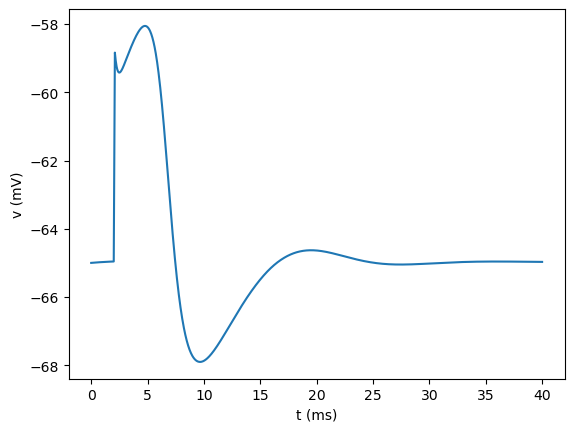

In [55]:
iclamp.amp = 0.8
h.finitialize(-65 * mV)
h.continuerun(40 * ms)
plt.figure()
plt.plot(t, v)
plt.xlabel('t (ms)')
plt.ylabel('v (mV)')
plt.show()

We can also record the ion current similar to the way we record the voltage

In [29]:
v = h.Vector().record(soma(0.5)._ref_v)             # Membrane potential vector
t = h.Vector().record(h._ref_t)                     # Time stamp vector
ina = h.Vector().record(soma(0.5)._ref_ina)
ik = h.Vector().record(soma(0.5)._ref_ik)      

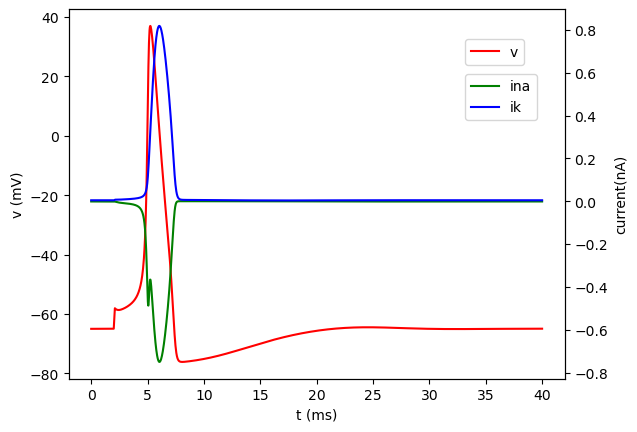

In [47]:
h.finitialize(-65 * mV)
h.continuerun(40 * ms)
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(t, v, label='v', c='r')
ax2.plot(t, ina, label='ina', c='g')
ax2.plot(t, ik, label='ik', c='b')
ax1.set_xlabel('t (ms)')
ax1.set_ylabel('v (mV)')
ax2.set_ylabel('current(nA)')
ax1.legend(loc=(0.8, 0.85))
ax2.legend(loc=(0.8, 0.7))

Pickles are a Python-specific data exchange format.
Python provides the pickle module to read and write pickled files. We load it via:

In [26]:
import pickle

Save the data as a dictionary

In [27]:
with open('data.p', 'wb') as f: # data.p is the file name
    pickle.dump({'t': t, 'v': v}, f)

Load the data

In [28]:
with open('data.p', 'rb') as f:
    data = pickle.load(f)
tnewp = data['t']
vnewp = data['v']

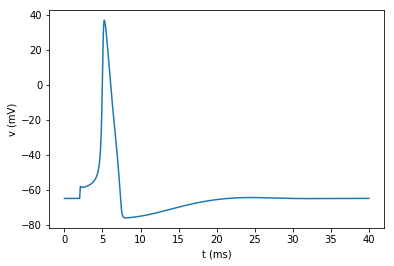

In [29]:
plt.figure()
plt.plot(tnewp, vnewp)
plt.xlabel('t (ms)')
plt.ylabel('v (mV)')
plt.show()

## Exercise 1: Try to create a soma with radius of 5um and insert the soma with HH channels. And simulate the soma with a current input of 0.9nA and 0.8nA respectively(delay=0 and dur=0.1). What's the  difference of the membrance potential?

In [8]:
## Uncomment the line below and fill in the blank
# from neuron import h
# from neuron.units import ms, mV
# %matplotlib inline
# import matplotlib.pyplot as plt
# import numpy as np

# h.load_file('stdrun.hoc')

# soma = ... ## create a soma
# soma.L = ... ## change the length
# ... = ... ## change the diameter

# soma.insert(...) ## insert the HH channels

# iclamp = ... ## insert the current input
# iclamp.delay = ... ## define the delay
# iclamp.dur = ... ## define the duration

# v = ... ## record the voltage
# t = ... ## record the time

# for i in range(2):
    # iclamp.amp = 0.8 + i * 0.1

    # h.finitialize(-65 * mV)
    # h.continuerun(40 * ms)

    # plt.figure()
    # plt.title(f'current is {0.8 + i * 0.1} nA')
    # plt.plot(t, v)
    # plt.xlabel('t(ms)')
    # plt.ylabel('V(mV)')

# Section 2: Simulation of a neuron with dendrites

In [1]:
from neuron import h
from neuron.units import ms, mV
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle

--No graphics will be displayed.


Normally, we are more interested in the neuron with spatial structures instead of the simple point neuron. In NEURON software, we also use the **h.Section(cylinder)** to represent the dendrites.

<center class='half'>
    <img src='./pictures/morpho.png' width='500'/>
    <img src='./pictures/morpho2.png' width='500'/>
</center>

## Step 1: Defining the cell morphology

A ball-and-stick cell by definition consists of two parts: the soma (ball) and a dendrite (stick). We could define two Sections at the top level as in the previous tutorial, but that wouldn't give us an easy way to create multiple cells. Instead, let's define a BallAndStick neuron class. The basic boilerplate for defining any class in Python looks like:

In [10]:
class BallAndStick:
    def __init__(self, gid):
        self._gid = gid
        self.soma = h.Section(name='soma', cell=self)
        self.dend = h.Section(name='dend', cell=self)
    def __repr__(self):
        return 'BallAndStick[{}]'.format(self._gid)

In [11]:
my_cell = BallAndStick(0)

In [12]:
h.topology()


|-|       soma(0-1)
|-|       BallAndStick[0].soma(0-1)
|-|       BallAndStick[0].dend(0-1)



1.0

In [6]:
my_other_cell = BallAndStick(1)

In [14]:
h.topology()


|-|       soma(0-1)
|-|       BallAndStick[0].soma(0-1)
|-|       BallAndStick[0].dend(0-1)
|-|       BallAndStick[1].soma(0-1)
|-|       BallAndStick[1].dend(0-1)



1.0

For now, we can get rid of my_other_cell:

In [7]:
del my_other_cell

In [8]:
h.topology()


|-|       BallAndStick[0].soma(0-1)
   `|       BallAndStick[0].dend1(0-1)
 `|       BallAndStick[0].dend0(0-1)



1.0

### Connect the sections

![morpho3](./pictures/morpho3.png)

We attach self.dend to the self.soma using the connect method:

In [33]:
class BallAndStick:
    def __init__(self, gid):
        self._gid = gid
        self.soma = h.Section(name='soma', cell=self)
        # self.dend = [h.Section(name='dend[%d]' % i, cell=self) for i in range(2)] # We can also use a list to store all the dendrites
        self.dend0 = h.Section(name='dend0', cell=self)
        self.dend1 = h.Section(name='dend1', cell=self)
        self.dend0.connect(self.soma(0))
        self.dend1.connect(self.soma(1))
    def __repr__(self):
        return 'BallAndStick[{}]'.format(self._gid)

In [3]:
my_cell = BallAndStick(0)

In [4]:
h.topology()


|-|       BallAndStick[0].soma(0-1)
   `|       BallAndStick[0].dend1(0-1)
 `|       BallAndStick[0].dend0(0-1)



1.0

### Define stylized geometry

Let's set the length and the width for both sections. We'll make the soma have length and diameter of 12.6157 microns, the dendrite have length 200 microns and diameter 1 micron.

In [55]:
class BallAndStick:
    def __init__(self, gid):
        self._gid = gid
        self.soma = h.Section(name='soma', cell=self)
        # self.dend = [h.Section(name='dend[%d]' % i, cell=self) for i in range(2)] # We can also use a list to store all the dendrites
        self.dend0 = h.Section(name='dend0', cell=self)
        self.dend1 = h.Section(name='dend1', cell=self)
        self.dend0.connect(self.soma(0))
        self.dend1.connect(self.soma(1))
        self.soma.L = self.soma.diam = 12.6157
        self.dend0.L = 200
        self.dend0.diam = 1
        self.dend1.L = 100
        self.dend1.diam = 2
    def __repr__(self):
        return 'BallAndStick[{}]'.format(self._gid)

my_cell = BallAndStick(0)

In [56]:
my_cell.soma(0.5).area()

500.00296377255506

In [57]:
h.topology()


|-|       BallAndStick[0].soma(0-1)
   `|       BallAndStick[0].dend1(0-1)
 `|       BallAndStick[0].dend0(0-1)
|-|       soma(0-1)
|-|       BallAndStick[0].soma(0-1)
 `|       BallAndStick[0].dend0(0-1)
|-|       BallAndStick[1].soma(0-1)
 `|       BallAndStick[1].dend0(0-1)
|-|       BallAndStick[2].soma(0-1)
 `|       BallAndStick[2].dend0(0-1)
|-|       BallAndStick[3].soma(0-1)
 `|       BallAndStick[3].dend0(0-1)
|-|       BallAndStick[4].soma(0-1)
 `|       BallAndStick[4].dend0(0-1)
|-|       BallAndStick[5].soma(0-1)
 `|       BallAndStick[5].dend0(0-1)
|-|       BallAndStick[6].soma(0-1)
 `|       BallAndStick[6].dend0(0-1)
|-|       BallAndStick[7].soma(0-1)
 `|       BallAndStick[7].dend0(0-1)
|-|       BallAndStick[8].soma(0-1)
 `|       BallAndStick[8].dend0(0-1)
|-|       BallAndStick[9].soma(0-1)
 `|       BallAndStick[9].dend0(0-1)
|-|       BallAndStick[0].soma(0-1)
   `|       BallAndStick[0].dend1(0-1)
 `|       BallAndStick[0].dend0(0-1)



1.0

## Step 2:  Specify biophysics

Our cell needs biophysical mechanisms in the membrane. We start by setting axial resistance and membrane capacitance. (Recall: NEURON's default axial resistance is appropriate for squid but low for mammalian models.)

In [58]:
class BallAndStick:
    def __init__(self, gid):
        self._gid = gid
        self.soma = h.Section(name='soma', cell=self)
        # self.dend = [h.Section(name='dend[%d]' % i, cell=self) for i in range(2)] # We can also use a list to store all the dendrites
        self.dend0 = h.Section(name='dend0', cell=self)
        self.dend1 = h.Section(name='dend1', cell=self)
        self.all = [self.soma, self.dend0, self.dend1]                                     # <-- NEW
        self.dend0.connect(self.soma(0))
        self.dend1.connect(self.soma(1))
        self.soma.L = self.soma.diam = 12.6157
        self.dend0.L = 200
        self.dend0.diam = 1
        self.dend1.L = 100
        self.dend1.diam = 2
        for sec in self.all:                                                  # <-- NEW
            sec.Ra = 100    # Axial resistance in Ohm * cm                    # <-- NEW
            sec.cm = 1      # Membrane capacitance in micro Farads / cm^2     # <-- NEW
    def __repr__(self):
        return 'BallAndStick[{}]'.format(self._gid)

my_cell = BallAndStick(0)

We've added a new variable **self.all** which is a list of all the sections in the cell. This will help us iterate over them to -- in this case -- specify axial resistance and membrane capacitance, but can also be used for any other biophysics.

This is getting a little complicated. Let's split __init__ into several functions:

In [59]:
class BallAndStick:
    def __init__(self, gid):
        self._gid = gid
        self._setup_morphology()
        self._setup_biophysics()

    def _setup_morphology(self):
        self.soma = h.Section(name='soma', cell=self)
        # self.dend = [h.Section(name='dend[%d]' % i, cell=self) for i in range(2)] # We can also use a list to store all the dendrites
        self.dend0 = h.Section(name='dend0', cell=self)
        self.dend1 = h.Section(name='dend1', cell=self)
        self.all = [self.soma, self.dend0, self.dend1]                                     # <-- NEW
        self.dend0.connect(self.soma(0))
        self.dend1.connect(self.soma(1))
        self.soma.L = self.soma.diam = 12.6157
        self.dend0.L = 200
        self.dend0.diam = 1
        self.dend1.L = 100
        self.dend1.diam = 2

    def _setup_biophysics(self):
        for sec in self.all:
            sec.Ra = 100    # Axial resistance in Ohm * cm
            sec.cm = 1      # Membrane capacitance in micro Farads / cm^2
            
    def __repr__(self):
        return 'BallAndStick[{}]'.format(self._gid)

my_cell = BallAndStick(0)

We'll put Hodgkin-Huxley (hh) kinetics in the soma and specify some parameters:

In [60]:
class BallAndStick:
    def __init__(self, gid):
        self._gid = gid
        self._setup_morphology()
        self._setup_biophysics()
    def _setup_morphology(self):
        self.soma = h.Section(name='soma', cell=self)
        # self.dend = [h.Section(name='dend[%d]' % i, cell=self) for i in range(2)] # We can also use a list to store all the dendrites
        self.dend0 = h.Section(name='dend0', cell=self)
        self.dend1 = h.Section(name='dend1', cell=self)
        self.all = [self.soma, self.dend0, self.dend1]                                     # <-- NEW
        self.dend0.connect(self.soma(0))
        self.dend1.connect(self.soma(1))
        self.soma.L = self.soma.diam = 12.6157
        self.dend0.L = 200
        self.dend0.diam = 1
        self.dend1.L = 100
        self.dend1.diam = 2
    def _setup_biophysics(self):
        for sec in self.all:
            sec.Ra = 100    # Axial resistance in Ohm * cm
            sec.cm = 1      # Membrane capacitance in micro Farads / cm^2
        self.soma.insert('hh')                                                    # <-- NEW           
        for seg in self.soma:                                                     # <-- NEW
            seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2                   # <-- NEW
            seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2                # <-- NEW
            seg.hh.gl = 0.0003    # Leak conductance in S/cm2                     # <-- NEW
            seg.hh.el = -54.3     # Reversal potential in mV                      # <-- NEW
    def __repr__(self):
        return 'BallAndStick[{}]'.format(self._gid)

my_cell = BallAndStick(0)

Finally, let's insert a passive (leak) current in the dendrite:

In [61]:
class BallAndStick:
    def __init__(self, gid):
        self._gid = gid
        self._setup_morphology()
        self._setup_biophysics()
    def _setup_morphology(self):
        self.soma = h.Section(name='soma', cell=self)
        # self.dend = [h.Section(name='dend[%d]' % i, cell=self) for i in range(2)] # We can also use a list to store all the dendrites
        self.dend0 = h.Section(name='dend0', cell=self)
        self.dend1 = h.Section(name='dend1', cell=self)
        self.all = [self.soma, self.dend0, self.dend1]                                     # <-- NEW
        self.dend0.connect(self.soma(0))
        self.dend1.connect(self.soma(1))
        self.soma.L = self.soma.diam = 12.6157
        self.dend0.L = 200
        self.dend0.diam = 1
        self.dend1.L = 100
        self.dend1.diam = 2
    def _setup_biophysics(self):
        for sec in self.all:
            sec.Ra = 100    # Axial resistance in Ohm * cm
            sec.cm = 1      # Membrane capacitance in micro Farads / cm^2
        self.soma.insert('hh')                                          
        for seg in self.soma:
            seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
            seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
            seg.hh.gl = 0.0003    # Leak conductance in S/cm2
            seg.hh.el = -54.3     # Reversal potential in mV
        # Insert passive current in the dendrite                       # <-- NEW
        self.dend0.insert('pas')                                        # <-- NEW
        for seg in self.dend0:                                          # <-- NEW
            seg.pas.g = 0.001  # Passive conductance in S/cm2          # <-- NEW
            seg.pas.e = -65    # Leak reversal potential mV            # <-- NEW 
        # Insert passive current in the dendrite                       # <-- NEW
        self.dend1.insert('pas')                                        # <-- NEW
        for seg in self.dend1:                                          # <-- NEW
            seg.pas.g = 0.001  # Passive conductance in S/cm2          # <-- NEW
            seg.pas.e = -65    # Leak reversal potential mV            # <-- NEW 
    def __repr__(self):
        return 'BallAndStick[{}]'.format(self._gid)

my_cell = BallAndStick(0)

### Derivation of the Cable Equation
Let's consider a piece of cylindric dendrite with length $dx$. The circuit diagram of this dendritic segment is shown in the schematic drawing below

<img src="./pictures/drawing.png" alt="Drawing" style="width: 400px;"/>

Using Kirchhoff’s laws, we find equations that relate the voltage $v(x)$ across the membrane at location $x$ with longitudinal and transversal currents. First, a longitudinal current $i(x)$ passing through the dendrite causes a voltage drop across the longitudinal resistor $R_L$ according to Ohm’s law,

\begin{equation}
v(x+dx,t)−v(x,t)=-R_Li(x,t) \ \ \ \ \ \ \ \   (1)
\end{equation}

where $v(x+dx,t)$ is the membrane potential at the neighbouring point $x+dx$. Second, the transversal current that passes through the RC-circuit is given by $C\frac{\partial }{\partial t}v(x,t)+\sum_{ion}I_{ion}-I_{ext}$, where the sum runs over all ion channel types present in the dendrite. Kirchhoff’s law regarding the conservation of current at each node leads to

\begin{equation}
-i(x+dx,t)+i(x,t)=C\frac{\partial }{\partial t}v(x,t)+\sum_{ion}I_{ion}-I_{ext}(x,t).   \ \ \ \ \ \ \ \   (2)
\end{equation}

The values of the longitudinal resistance $R_L$, the capacity $C$, the ionic currents as well as the externally applied current can be expressed in terms of specific quantities per unit length $r_L$, $c$, $i_{ion}$ and $i_{ext}$, respectively.

\begin{equation}
R_L=r_Ldx, C=cdx, I_{ext}(x,t)=i_{ext}(x,t)dx, I_{ion}(x,t)=i_{ion}(x,t)dx.  \ \ \ \ \ \ \ \   (3)
\end{equation}

These scaling relations express the fact that the longitudinal resistance and the capacitance increases with the length of the cylinder. Similarly, the total amount of transversal current increases with the length $dx$ simply because the surface through which the current can pass is increasing. Substituting these expressions in Eqs. (1) and (2), dividing by $dx$, and taking the limit $dx→0$ leads to

\begin{equation}
\begin{split}
\frac{\partial}{\partial x}v(x,t)&=r_Li(x,t)\ \ \ \ \ \ \ \   (4a)\\
\frac{\partial}{\partial x}i(x,t)&=c\frac{\partial }{\partial t}v(x,t)+\sum_{ion}i_{ion}(x,t)−i_{ext}(x,t).\ \ \ \ \ \ \ \   (4b)
\end{split}
\end{equation}

Taking the derivative of equation (4a) with respect to $x$ and substituting the result into (4b) yields

\begin{equation}
\frac{\partial^2}{\partial x^2}v(x,t)=cr_L\frac{\partial}{\partial t}v(x,t)+r_L\sum_{ion}i_{ion}(x,t)−r_Li_{ext}(x,t). \ \ \ \ \ \ \ \   (5)
\end{equation}

Eq. (5) is called the general cable equation.

Reference: https://neuronaldynamics.epfl.ch 

## Step 3: Simulation and record

We'll inject a current pulse into the distal (1) end of the dendrite starting 5 ms after the simulation starts, with a duration of 1 ms, and an amplitude of 0.1 nA. First, let's define and position the current clamp object:

In [62]:
stim = h.IClamp(my_cell.dend0(1))

In [63]:
stim.delay = 5
stim.dur = 1
stim.amp = 0.1

If we want, we can check the segment the current clamp is inserted into:

In [64]:
stim.get_segment()

BallAndStick[0].dend0(1)

We'll start out recording the membrane potential at the center of the soma and the time in two NEURON Vectors:

In [65]:
soma_v = h.Vector().record(my_cell.soma(0.5)._ref_v)
t = h.Vector().record(h._ref_t)

In [66]:
h.load_file('stdrun.hoc')
h.finitialize(-65 * mV)
h.continuerun(25 * ms)

0.0

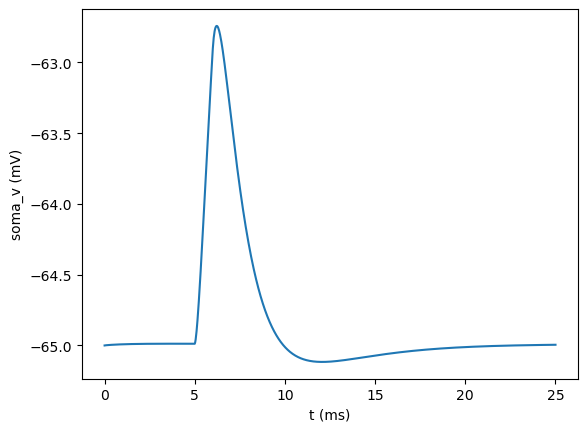

In [67]:
plt.figure()
plt.plot(t, soma_v)
plt.xlabel('t (ms)')
plt.ylabel('soma_v (mV)')
plt.show()

### Plotting both the dendrite and the soma

In [68]:
dend0_v = h.Vector().record(my_cell.dend0(0.5)._ref_v)

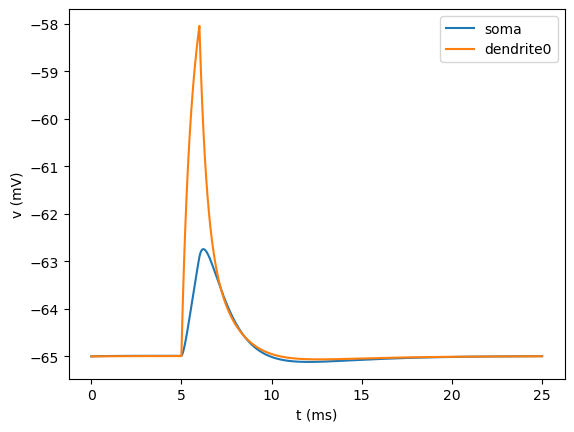

In [70]:
stim.amp = 0.1
h.finitialize(-65 * mV)
h.continuerun(25 * ms)
plt.figure()
plt.plot(t, soma_v, label='soma')
plt.plot(t, dend0_v, label='dendrite0')
plt.xlabel('t (ms)')
plt.ylabel('v (mV)')
plt.legend()
plt.show()

## Exercise 2.1 : You can have a try that if you change the amplitude of the stimulus, how will the voltage of soma and dendrite change respectively?

### The role of nseg

In [71]:
my_cell.dend0.psection()

{'point_processes': {'IClamp': {IClamp[0]}},
 'density_mechs': {'pas': {'g': [0.001],
   'e': [-65.0],
   'i': [2.310476020070951e-06]}},
 'ions': {},
 'morphology': {'L': 200.0,
  'diam': [1.0],
  'pts3d': [],
  'parent': BallAndStick[0].soma(0),
  'trueparent': None},
 'nseg': 1,
 'Ra': 100.0,
 'cm': [1.0],
 'regions': set(),
 'species': set(),
 'name': 'BallAndStick[0].dend0',
 'hoc_internal_name': '__nrnsec_0x55d670e87fa0',
 'cell': BallAndStick[0]}

**section.nseg** : The section is divided into nseg compartments of length L/nseg. Membrane potential will be computed at the ends of the section and the middle of each compartment. At the midpoint of each segment, the difference equation satisfies the law of conservation of current. Therefore, the more segments are divided, the higher the numerical accuracy.

![segment](./pictures/segment.png)

In [72]:
my_cell.dend0.nseg = 5

Normally, nseg is set to be an odd number for convenience

In [73]:
dend_v_1 = h.Vector().record(my_cell.dend0(0)._ref_v)
dend_v_2 = h.Vector().record(my_cell.dend0(0.5)._ref_v)
dend_v_3 = h.Vector().record(my_cell.dend0(1)._ref_v)

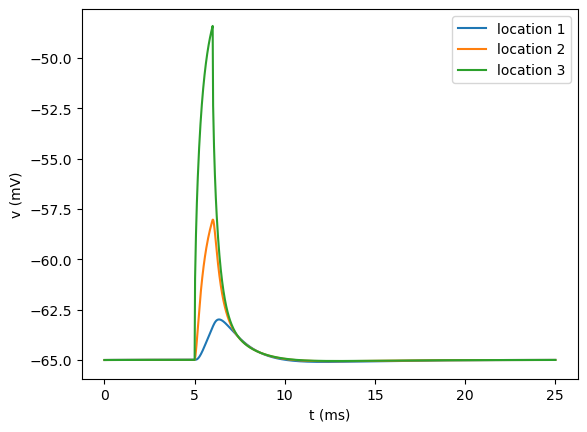

In [74]:
stim.amp = 0.1
h.finitialize(-65 * mV)
h.continuerun(25 * ms)
plt.figure()
plt.plot(t, dend_v_1, label='location 1')
plt.plot(t, dend_v_2, label='location 2')
plt.plot(t, dend_v_3, label='location 3')
plt.xlabel('t (ms)')
plt.ylabel('v (mV)')
plt.legend()
plt.show()

## Exercise 2.2: Try to build a neuron with a soma connected with a dendrite. Change the nseg of the dendrite to see how the nseg affects the resolution of the simulation?

In [75]:
## Uncomment the code below and fill in the blank

# class BallAndStick:
#     def __init__(self, gid):
#         self._gid = gid
#         self._setup_morphology()
#         self._setup_biophysics()
#     def _setup_morphology(self):
#         self.soma = h.Section(name='soma', cell=self)
#         self.dend = h.Section(name='dend', cell=self)
#         self.all = [self.soma, self.dend]
#         ... # connect the dend with soma
#         ... # change the length and diamter of soma to 12.6157um
#         ... # change the length of dendrite to 200um
#         ... # change the diameter of dendrite to 1um
#     def _setup_biophysics(self):
#         for sec in self.all:
#             sec.Ra = 100    # Axial resistance in Ohm * cm
#             sec.cm = 1      # Membrane capacitance in micro Farads / cm^2
#         ....insert('hh') # Insert HH channel in soma                                       
#         for seg in self.soma:
#             seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
#             seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
#             seg.hh.gl = 0.0003    # Leak conductance in S/cm2
#             seg.hh.el = -54.3     # Reversal potential in mV                      
#         ....insert('pas')  # Insert passive channel in dendrite                                       
#         for seg in self.dend:                                          
#             seg.pas.g = 0.001  # Passive conductance in S/cm2         
#             seg.pas.e = -65    # Leak reversal potential mV            
#     def __repr__(self):
#         return 'BallAndStick[{}]'.format(self._gid)

# my_cell = BallAndStick(0)

# stim = h.IClamp(...) #stimulate the neuron at dend0(1)
# stim.delay = 5
# stim.dur = 1
# stim.amp = 0.3

# soma_v = h.Vector().record(my_cell.soma(0.5)._ref_v)
# dend_v = h.Vector().record(my_cell.dend(0.5)._ref_v)
# t = h.Vector().record(h._ref_t)

# plt.figure()
# colors = ['green', 'blue', 'red', 'black']
# for my_cell.dend.nseg in [1, 101]:
#     h.finitialize(-65)
#     h.continuerun(25)
#     if my_cell.dend.nseg == 1:
#         plt.plot(t, soma_v, label=f'soma_v when nseg is {my_cell.dend.nseg}', color = 'green')
#         plt.plot(t, dend_v, ls='--', label=f'dend_v when nseg is {my_cell.dend.nseg}', color = 'green')
#     else:
#         plt.plot(t, soma_v, label=f'soma_v when nseg is {my_cell.dend.nseg}', color = 'red')
#         plt.plot(t, dend_v, ls='--', label=f'dend_v when nseg is {my_cell.dend.nseg}', color = 'red')
# plt.xlabel('t(ms)')
# plt.ylabel('MP(mV)')
# plt.legend()
# plt.show()

# Section 3: Simulation of neuronal network

In [2]:
from neuron import h
from neuron.units import ms, mV
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
h.load_file('stdrun.hoc')


--No graphics will be displayed.


1.0

## Step 1: connect the neurons via synapses

In [3]:
class BallAndStick:
    def __init__(self, gid):
        self._gid = gid
        self._setup_morphology()
        self._setup_biophysics()
    def _setup_morphology(self):
        self.soma = h.Section(name='soma', cell=self)
        self.dend0 = h.Section(name='dend0', cell=self)
        self.all = [self.soma, self.dend0]                                     
        self.dend0.connect(self.soma(0))
        self.soma.L = self.soma.diam = 12.6157
        self.dend0.L = 200
        self.dend0.diam = 1
    def _setup_biophysics(self):
        for sec in self.all:
            sec.Ra = 100    # Axial resistance in Ohm * cm
            sec.cm = 1      # Membrane capacitance in micro Farads / cm^2
        self.soma.insert('hh')                                          
        for seg in self.soma:
            seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
            seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
            seg.hh.gl = 0.0003    # Leak conductance in S/cm2
            seg.hh.el = -54.3     # Reversal potential in mV
        # Insert passive current in the dendrite                       
        self.dend0.insert('pas')                                        
        for seg in self.dend0:                                         
            seg.pas.g = 0.001  # Passive conductance in S/cm2          
            seg.pas.e = -65    # Leak reversal potential mV            
    def __repr__(self):
        return 'BallAndStick[{}]'.format(self._gid)

Create N neurons using a list

In [3]:
neuron_num = 10
neurons = [BallAndStick(i) for i in range(neuron_num)]

In [4]:
neurons[0]

BallAndStick[0]

In [5]:
h.topology()


|-|       BallAndStick[0].soma(0-1)
 `|       BallAndStick[0].dend0(0-1)
|-|       BallAndStick[1].soma(0-1)
 `|       BallAndStick[1].dend0(0-1)
|-|       BallAndStick[2].soma(0-1)
 `|       BallAndStick[2].dend0(0-1)
|-|       BallAndStick[3].soma(0-1)
 `|       BallAndStick[3].dend0(0-1)
|-|       BallAndStick[4].soma(0-1)
 `|       BallAndStick[4].dend0(0-1)
|-|       BallAndStick[5].soma(0-1)
 `|       BallAndStick[5].dend0(0-1)
|-|       BallAndStick[6].soma(0-1)
 `|       BallAndStick[6].dend0(0-1)
|-|       BallAndStick[7].soma(0-1)
 `|       BallAndStick[7].dend0(0-1)
|-|       BallAndStick[8].soma(0-1)
 `|       BallAndStick[8].dend0(0-1)
|-|       BallAndStick[9].soma(0-1)
 `|       BallAndStick[9].dend0(0-1)



1.0

### Synapse

Biologically, neurons are connected via synapses

![synapse](./pictures/synapse.png)

Mathematically, we are use the following model to build a synapse:
$$
I_{syn}=g_{syn}(t)(u(t)-E_{syn})
$$
$$
g_{syn}=\bar{g}_{syn}e^{(-(t-t^f)/\tau)}\Theta(t-t^f).
$$
or
$$
g_{syn}=\bar{g}_{syn}e^{(-(t-t^f)/\tau_1)}(1-e^{(-(t-t^f)/\tau_2)})\Theta(t-t^f).
$$
For inhibitory synapses $E_{syn}$ is usually set to −75 mV, whereas for excitatory synapses $E_{syn} \approx 0$. And $\tau$ is the time constant.

![synaptic_I](./pictures/synaptic_I.png)

Event-based communication between objects in NEURON takes place via network connection objects called **NetCon**. Each NetCon has a source and target, where the source is typically a spike threshold detector. When a spike is detected, the NetCon sends a message to a target, usually a synapse on a postsynaptic cell.

A **NetStim** is a spike generator that can be used as the source in a NetCon, behaving as external input onto the synapse of a target cell. The following code makes a NetStim object that generates one spike at time t=9. The NetCon then adds another ms delay to deliver a synaptic event at time t=10 onto the first cell.

The code below makes a stimulator and attaches it to a synapse object (**ExpSyn**) that behaves much like an AMPA synapse – it conducts current as a decaying exponential function.

In [6]:
stim = h.NetStim() # Make a new stimulator

# Attach it to a synapse in the middle of the dendrite
# of the first cell in the network. (Named 'syn_' to avoid
# being overwritten with the 'syn' var assigned later.)

syn_ = h.ExpSyn(neurons[0].dend0(0.5))

stim.number = 1
stim.start = 9
ncstim = h.NetCon(stim, syn_)
ncstim.delay = 1 * ms
ncstim.weight[0] = 0.04 # NetCon weight is a vector.

Exponentially decaying currents, such as that generated by the synapse syn_ have dynamics that depend on tau, the time constant. Let's specify a time constant of 2 ms:

In [7]:
syn_.tau = 2 * ms

The parameter tau specifies how quickly the currents decay. The exact value of the current depends on the cell's membrane potential, and the synapse's reversal potential, syn_.e.

In [21]:
print('Reversal potential = {} mV'.format(syn_.e))

Reversal potential = 0.0 mV


# Step 2: Running and plotting a simulation

In [7]:
recording_cell = neurons[0]
soma_v = h.Vector().record(recording_cell.soma(0.5)._ref_v)
dend_v = h.Vector().record(recording_cell.dend0(0.5)._ref_v)
t = h.Vector().record(h._ref_t)

In [23]:
h.finitialize(-65 * mV)
h.continuerun(25 * ms)

0.0

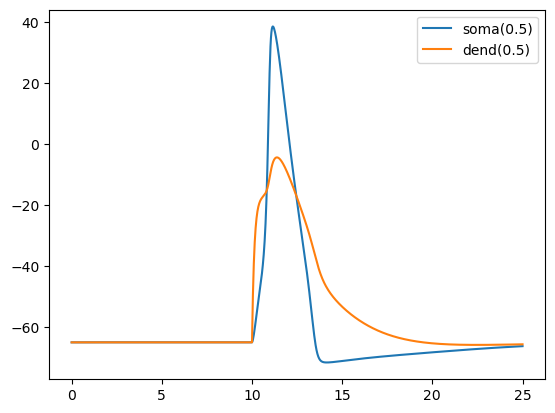

In [24]:
plt.plot(t, soma_v, label='soma(0.5)')
plt.plot(t, dend_v, label='dend(0.5)')
plt.legend()
plt.show()

Change the excitatory synapse to an inhibitory one

In [25]:
syn_.e = -75 * mV

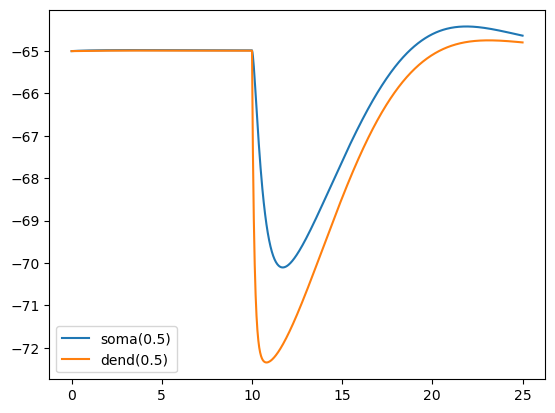

In [26]:
h.finitialize(-65 * mV)
h.continuerun(25 * ms)
plt.plot(t, soma_v, label='soma(0.5)')
plt.plot(t, dend_v, label='dend(0.5)')
plt.legend()
plt.show()

To understand the above graph, we may wish to consider the time series of synaptic current. Let's create a new Vector to monitor that:

In [27]:
syn_.e = 0 * mV
syn_i = h.Vector().record(syn_._ref_i)

In [28]:
h.finitialize(-65 * mV)
h.continuerun(25 * ms)

0.0

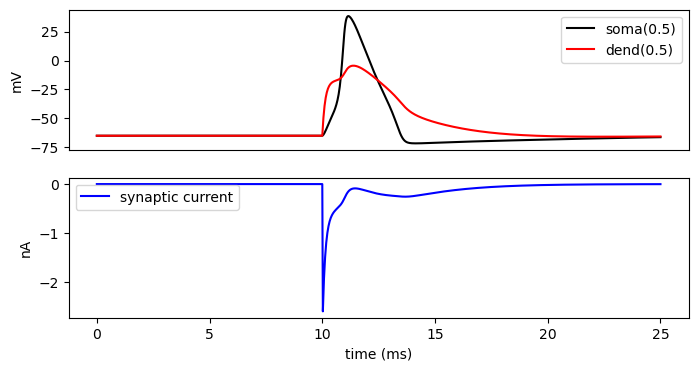

In [29]:
fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(2, 1, 1)
soma_plot = ax1.plot(t, soma_v, color='black', label='soma(0.5)')
dend_plot = ax1.plot(t, dend_v, color='red', label='dend(0.5)')
ax1.legend()
ax1.set_ylabel('mV')
ax1.set_xticks([]) # Use ax2's tick labels

ax2 = fig.add_subplot(2, 1, 2)
syn_plot = ax2.plot(t, syn_i, color='blue', label='synaptic current')
ax2.legend()
ax2.set_ylabel(h.units('ExpSyn.i'))
ax2.set_xlabel('time (ms)')
plt.show()

We can also the Netstim to generate inputs with uniform distribution or Poisson distribution

**stim.noise** is used to control the randomness of the inputs: 0 for uniform and 1 for Poisson. **stim.interval** is used to control the rate the inputs

In [32]:
stim.number = 10
stim.interval = 10
stim.start = 0
stim.noise = 0 # uniform
ncstim = h.NetCon(stim, syn_)
ncstim.delay = 0 * ms
ncstim.weight[0] = 0.04 # NetCon weight is a vector.

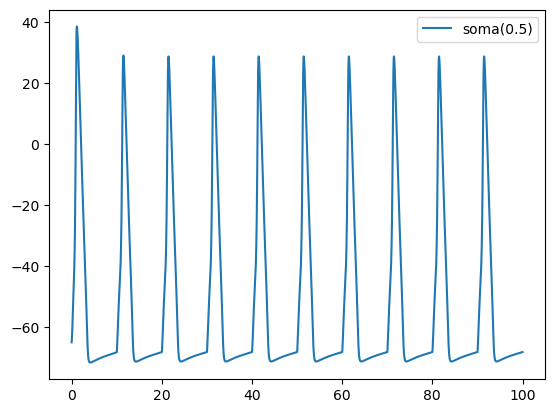

In [33]:
h.finitialize(-65 * mV)
h.continuerun(100 * ms)
plt.plot(t, soma_v, label='soma(0.5)')
plt.legend()
plt.show()

In [8]:
stim.number = 10
stim.interval = 10
stim.start = 0
stim.noise = 1 # Poisson
ncstim = h.NetCon(stim, syn_)
ncstim.delay = 0 * ms
ncstim.weight[0] = 0.04 # NetCon weight is a vector.

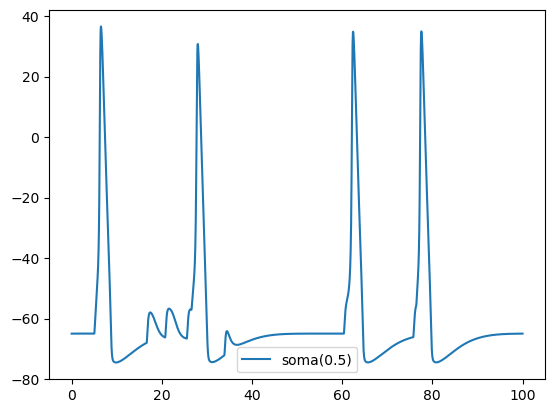

In [9]:
h.finitialize(-65 * mV)
h.continuerun(100 * ms)
plt.plot(t, soma_v, label='soma(0.5)')
plt.legend()
plt.show()

### Use the NetCon to record the spike time

**NetCon = (source, target)**, The target is allowed to be None in which case the NetCon is always inactive. However this can be useful for recording the spike train from an output cell.

In [10]:
recording_cell = neurons[0]
soma_v = h.Vector().record(recording_cell.soma(0.5)._ref_v)
dend_v = h.Vector().record(recording_cell.dend0(0.5)._ref_v)
t = h.Vector().record(h._ref_t)

In [11]:
spike_time = h.Vector()
nc_re = h.NetCon(recording_cell.soma(0.5)._ref_v, None, sec=recording_cell.soma)
nc_re.record(spike_time)

0.0

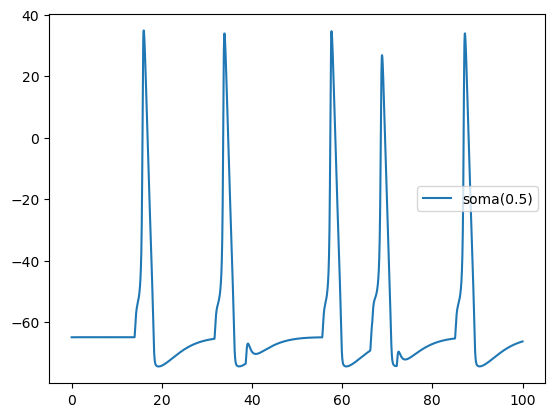

In [12]:
stim.number = 10
stim.interval = 10
stim.start = 0
stim.noise = 1 # Poisson
ncstim = h.NetCon(stim, syn_)
ncstim.delay = 0 * ms
ncstim.weight[0] = 0.04 # NetCon weight is a vector
h.finitialize(-65 * mV)
h.continuerun(100 * ms)
plt.plot(t, soma_v, label='soma(0.5)')
plt.legend()
plt.show()

In [13]:
print(np.array(spike_time))

[15.75  33.675 57.4   68.625 87.   ]


## Step 3: Connecting the neurons

 Next, we need to connect an axon from cell n to a synapse at the middle of the dendrite on cell n + 1. For this model, the particular dynamics of the axons do not need to be explicitly modeled. When the soma fires an action potential, we assume the spike propagates down the axon and induces a synaptic event onto the dendrite of the target cell with some delay. We can therefore connect a spike detector in the soma of the presynaptic cell that triggers a synaptic event in the target cell via a NetCon.

In [14]:
syns = []
netcons = []
for source, target in zip(neurons, neurons[1:] + [neurons[0]]):
    syn = h.ExpSyn(target.dend0(0.5))
    nc = h.NetCon(source.soma(0.5)._ref_v, syn, sec=source.soma)
    nc.weight[0] = 0.05
    nc.delay = 5
    netcons.append(nc)
    syns.append(syn)

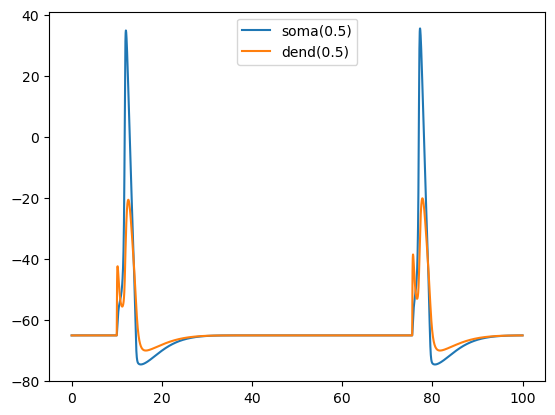

In [15]:
stim = h.NetStim() # Make a new stimulator
syn_ = h.ExpSyn(neurons[0].dend0(0.5))
stim.number = 1
stim.start = 9
ncstim = h.NetCon(stim, syn_)
ncstim.delay = 1 * ms
ncstim.weight[0] = 0.04 # NetCon weight is a vector.


h.finitialize(-65 * mV)
h.continuerun(100 * ms)
plt.plot(t, soma_v, label='soma(0.5)')
plt.plot(t, dend_v, label='dend(0.5)')
plt.legend()
plt.show()

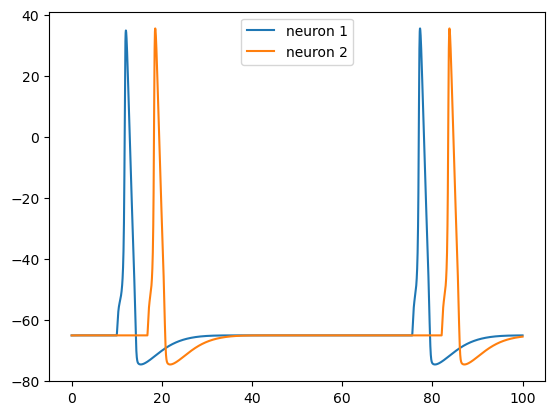

In [16]:
soma_v_1 = h.Vector().record(neurons[0].soma(0.5)._ref_v)
soma_v_2 = h.Vector().record(neurons[1].soma(0.5)._ref_v)
h.finitialize(-65 * mV)
h.continuerun(100 * ms)
plt.plot(t, soma_v_1, label='neuron 1')
plt.plot(t, soma_v_2, label='neuron 2')
plt.legend()
plt.show()

## Step 4: Use netcon to record the spike time 

In [17]:
spike_times = [h.Vector() for nc in netcons]
for nc, spike_times_vec in zip(netcons, spike_times):
    nc.record(spike_times_vec)

In [18]:
stim.number = 1
stim.start = 9
ncstim = h.NetCon(stim, syn_)
ncstim.delay = 1 * ms
ncstim.weight[0] = 0.04 # NetCon weight is a vector.
h.finitialize(-65 * mV)
h.continuerun(100 * ms)

0.0

In [19]:
for i, spike_times_vec in enumerate(spike_times):
    print('cell {}: {}'.format(i, list(spike_times_vec)))

cell 0: [11.800000000099864, 77.05000000010895]
cell 1: [18.325000000099493, 83.57500000011044]
cell 2: [24.850000000099122, 90.10000000011192]
cell 3: [31.37500000009875, 96.6250000001134]
cell 4: [37.90000000010006]
cell 5: [44.42500000010154]
cell 6: [50.950000000103024]
cell 7: [57.47500000010451]
cell 8: [64.00000000010598]
cell 9: [70.52500000010747]


A more intuitive way of seeing this is to use a raster plot. Here's how to do that with matplotlib:

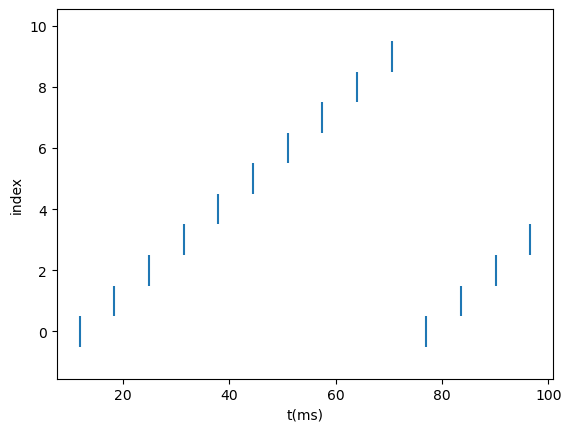

In [20]:
event = []
for spike_times_vec in spike_times:
    event.append(spike_times_vec)

plt.figure()
plt.eventplot(event)
plt.xlabel('t(ms)')
plt.ylabel('index')
plt.show()

## Step 5: Build a larger neuronal network with random connection

In [4]:
neurons = []
neuron_num = 100
for i in range(neuron_num):
    neurons.append(BallAndStick(i))

Create a random connectivity matrix

In [5]:
connectivity_matrix = np.random.randint(0, 2, (neuron_num, neuron_num))
connectivity_matrix[np.eye(neuron_num, dtype=np.bool)] = 0

Connectivity matrix is a 0-1 matrix with size $N \times N$. The element $c_{ij}=1$ means there is a synatic connection from neuron j to neuron i.

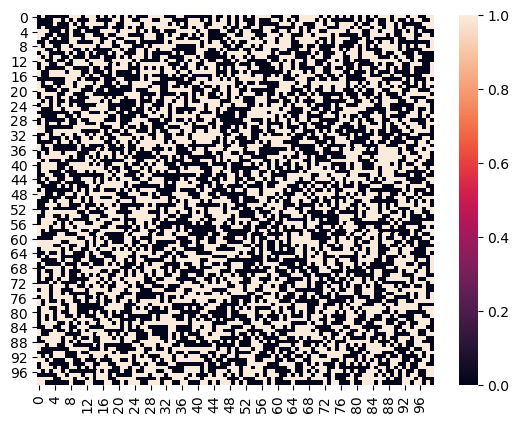

In [26]:
import seaborn as sns
sns.heatmap(connectivity_matrix)

In [72]:
syns = []
netcons = []
for i in range(neuron_num):
    for j in range(neuron_num):
        if connectivity_matrix[i][j] == 0:
            source = neurons[j]
            target = neurons[i]
            syn = h.ExpSyn(target.dend0(0.5))
            nc = h.NetCon(source.soma(0.5)._ref_v, syn, sec=source.soma)
            nc.weight[0] = 0.04
            nc.delay = 3
            netcons.append(nc)
            syns.append(syn)

In [73]:
len(netcons)

5024

In [74]:
spike_times = [h.Vector() for i in range(neuron_num)]
nc_res = [h.NetCon(neurons[i].soma(0.5)._ref_v, None, sec=neurons[i].soma) for i in range(neuron_num)]
for spike_time, nc_re in zip(spike_times, nc_res):
    nc_re.record(spike_time)

In [75]:
stim = h.NetStim() # Make a new stimulator
syn_ = h.ExpSyn(neurons[0].dend0(0.5))
stim.number = 1
stim.interval = 10
stim.start = 0
stim.noise = 0 
ncstim = h.NetCon(stim, syn_)
ncstim.delay = 0 * ms
ncstim.weight[0] = 0.04 # NetCon weight is a vector.

soma_v = h.Vector().record(neurons[0].soma(0.5)._ref_v)
soma_v_2 = h.Vector().record(neurons[1].soma(0.5)._ref_v)
t = h.Vector().record(h._ref_t)

h.finitialize(-65 * mV)
h.continuerun(100 * ms)

0.0

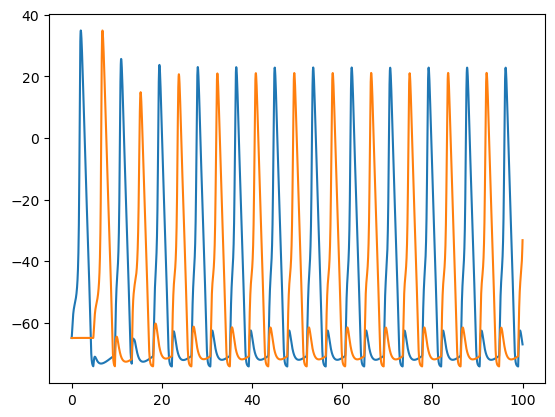

In [76]:
plt.plot(t, soma_v)
plt.plot(t, soma_v_2)

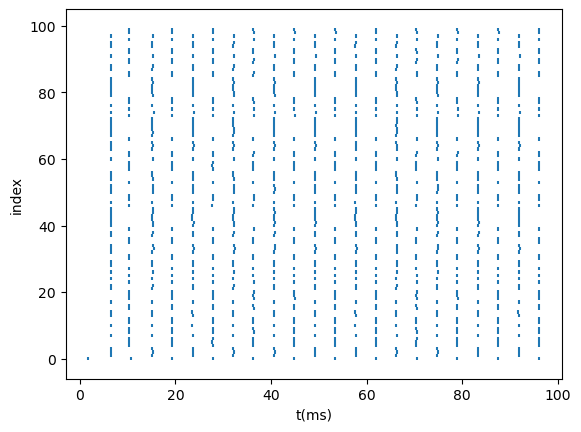

In [80]:
event = []
for spike_times_vec in spike_times:
    event.append(spike_times_vec)

plt.figure()
plt.eventplot(event)
plt.xlabel('t(ms)')
plt.ylabel('index')
plt.show()

## Exercise3(Advanced): Can you infer the connectivity matrix from the spike train of all neurons?

# Section 4: Simulation of a real neuron from ModelDB

In [1]:
from neuron import h
from neuron.units import ms, mV
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import plotly
from neuron import gui

--No graphics will be displayed.


## Step 1: Download the neuron file from ModelDB

ModelDB(https://senselab.med.yale.edu/ModelDB/) is a website that provides an accessible location for storing and efficiently retrieving computational neuroscience models

![ModelDB](./pictures/ModelDB.png)

For example: if we want to use the biophysical neuron in **Hay, E.,et al., 2011. PLoS Comput. Biol.**. We can search the first author on the website and find the neuron they use.(Most neuron models that is built by NEURON software can be found in ModelDB)

![ModelDB2](./pictures/ModelDB2.png)

After downloading the zip file, we can find the .mod and .hoc files. The .mod files define the ion channels they use in the model. The .hoc define the biophysical properties of the neuron and the simulation method

## Step 2: Load the .mod and .hoc file

Use **nrivmodl + file path** to load all the ion channels defined by the .mod files. If the ion channels are loaded succesfully, you can a **x86_64** file in your file folder

In [3]:
!nrnivmodl ./L5bPCmodelsEH/mod

Creating x86_64 directory for .o files.

/home/mjy/winter school 2023
ls: cannot access './L5bPCmodelsEH/mod/*.inc': No such file or directory
./L5bPCmodelsEH/mod/CaDynamics_E2.mod ./L5bPCmodelsEH/mod/Ca_HVA.mod ./L5bPCmodelsEH/mod/Ca_LVAst.mod ./L5bPCmodelsEH/mod/epsp.mod ./L5bPCmodelsEH/mod/Ih.mod ./L5bPCmodelsEH/mod/Im.mod ./L5bPCmodelsEH/mod/K_Pst.mod ./L5bPCmodelsEH/mod/K_Tst.mod ./L5bPCmodelsEH/mod/Nap_Et2.mod ./L5bPCmodelsEH/mod/NaTa_t.mod ./L5bPCmodelsEH/mod/NaTs2_t.mod ./L5bPCmodelsEH/mod/SK_E2.mod ./L5bPCmodelsEH/mod/SKv3_1.mod
CaDynamics_E2.mod Ca_HVA.mod Ca_LVAst.mod epsp.mod Ih.mod Im.mod K_Pst.mod K_Tst.mod Nap_Et2.mod NaTa_t.mod NaTs2_t.mod SK_E2.mod SKv3_1.mod
mkdir -p x86_64
 -> Compiling mod_func.c
/home/mjy/anaconda/envs/pytorch/bin/x86_64-conda_cos6-linux-gnu-cc -O2   -I. -I..   -I/home/mjy/anaconda/envs/pytorch/lib/python3.7/site-packages/neuron/.data/include  -I/nrnwheel/openmpi/include -fPIC -c mod_func.c -o mod_func.o
 -> NMODL CaDynamics_E2.mod
MODLUNIT=/home/m

The morphology and biophysical properties are written in the HOC language. So we can use **h.load_file to load** the .hoc file we need.

In [4]:
h.load_file('nrngui.hoc')
h.load_file("import3d.hoc")

morphologyFilename = "./L5bPCmodelsEH/morphologies/cell1.asc"
biophysicalModelFilename = "./L5bPCmodelsEH/models/L5PCbiophys1.hoc"
biophysicalModelTemplateFilename = "./L5bPCmodelsEH/models/L5PCtemplate.hoc"

h.load_file(biophysicalModelFilename)
h.load_file(biophysicalModelTemplateFilename)
L5PC = h.L5PCtemplate(morphologyFilename)

We can use **h.topology()** to check whether we load the neuron successfully.

In [5]:
h.topology()


|-|       L5PCtemplate[0].soma[0](0-1)
  `|       L5PCtemplate[0].dend[0](0-1)
    `|       L5PCtemplate[0].dend[1](0-1)
      `------|       L5PCtemplate[0].dend[2](0-1)
      `|       L5PCtemplate[0].dend[3](0-1)
        `----|       L5PCtemplate[0].dend[4](0-1)
        `--------|       L5PCtemplate[0].dend[5](0-1)
    `------|       L5PCtemplate[0].dend[6](0-1)
  `|       L5PCtemplate[0].dend[7](0-1)
    `|       L5PCtemplate[0].dend[8](0-1)
      `|       L5PCtemplate[0].dend[9](0-1)
      `--|       L5PCtemplate[0].dend[10](0-1)
    `|       L5PCtemplate[0].dend[11](0-1)
      `|       L5PCtemplate[0].dend[12](0-1)
        `------|       L5PCtemplate[0].dend[13](0-1)
        `------|       L5PCtemplate[0].dend[14](0-1)
      `--|       L5PCtemplate[0].dend[15](0-1)
  `|       L5PCtemplate[0].dend[16](0-1)
    `|       L5PCtemplate[0].dend[17](0-1)
      `|       L5PCtemplate[0].dend[18](0-1)
        `|       L5PCtemplate[0].dend[19](0-1)
        `|       L5PCtemplate[0].dend[20](

1.0

Or we can sketch the morphology of the neuron

In [7]:
ps = h.PlotShape(True)
ps.plot(plotly).show()

And we can use **.psection()** to check the neuron in detail.

In [8]:
L5PC.soma[0].psection()

{'point_processes': {},
 'density_mechs': {'pas': {'g': [3.44e-05], 'e': [-90.0], 'i': [0.0]},
  'CaDynamics_E2': {'gamma': [0.000549],
   'decay': [486.0],
   'depth': [0.1],
   'minCai': [0.0001]},
  'Ca_HVA': {'gCa_HVAbar': [0.000567],
   'ica': [0.0],
   'gCa_HVA': [0.0],
   'm': [0.0],
   'h': [0.0]},
  'Ca_LVAst': {'gCa_LVAstbar': [0.00432],
   'ica': [0.0],
   'gCa_LVAst': [0.0],
   'm': [0.0],
   'h': [0.0]},
  'Ih': {'gIhbar': [0.0002], 'ihcn': [0.0], 'gIh': [0.0], 'm': [0.0]},
  'K_Pst': {'gK_Pstbar': [0.000547],
   'ik': [0.0],
   'gK_Pst': [0.0],
   'm': [0.0],
   'h': [0.0]},
  'K_Tst': {'gK_Tstbar': [0.0326],
   'ik': [0.0],
   'gK_Tst': [0.0],
   'm': [0.0],
   'h': [0.0]},
  'Nap_Et2': {'gNap_Et2bar': [0.00496],
   'ina': [0.0],
   'gNap_Et2': [0.0],
   'm': [0.0],
   'h': [0.0]},
  'NaTa_t': {'gNaTa_tbar': [1.71],
   'ina': [0.0],
   'gNaTa_t': [0.0],
   'm': [0.0],
   'h': [0.0]},
  'SK_E2': {'gSK_E2bar': [0.0556], 'ik': [0.0], 'gSK_E2': [0.0], 'z': [0.0]},
  'SKv3_1'

## Step 3: Simulate the neuron as we like

We can also the **h.Vector** to record the time and voltage

In [9]:
soma_v = h.Vector().record(L5PC.soma[0](0.5)._ref_v)
t = h.Vector().record(h._ref_t)

We can either simulate the neuron with a current input or a synaptic input

In [10]:
iclamp = h.IClamp(L5PC.soma[0](0.5))
iclamp.dur = 5
iclamp.delay = 10

stim = h.NetStim()
syn = h.ExpSyn(L5PC.soma[0](0.5))
syn.tau = 1
stim.number = 10
stim.interval = 5
stim.noise = 1
stim.start = 10
ncstim = h.NetCon(stim, syn)
ncstim.delay = 0 * ms

In [11]:
iclamp.amp = 2
ncstim.weight[0] = 0
h.v_init = -80
h.tstop = 100
h.run()

0.0

Text(0.5, 1.0, 'When the neuron receives a current input')

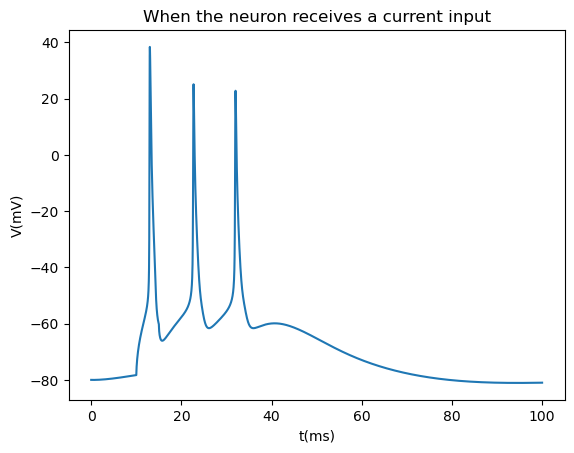

In [12]:
plt.plot(t, soma_v)
plt.xlabel('t(ms)')
plt.ylabel('V(mV)')
plt.title('When the neuron receives a current input')

In [13]:
iclamp.amp = 0
ncstim.weight[0] = 0.05
h.v_init = -80
h.tstop = 100
h.run()

0.0

Text(0.5, 1.0, 'When the neuron receives a synaptic input')

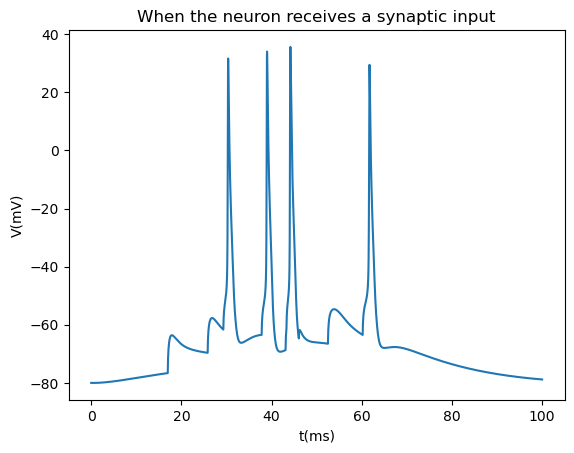

In [14]:
plt.plot(t, soma_v)
plt.xlabel('t(ms)')
plt.ylabel('V(mV)')
plt.title('When the neuron receives a synaptic input')

## Exercise 4(Advanced): Use the biophysical neuron model in https://github.com/LCNS-SJTU/DIF_model and check the bilinear rule.

![bilinear](./pictures/bilinear.png)

$$
V_S(t^*) = V_E(t^*)+V_I(t^*)+k*V_E(t^*)*V_I(t^*)

# End of tutorial